# Keras costs visualizations
In this notebook we will visualize different costs associated with different popular architectures

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import json
report_paths = ["timings/VGG16_06-24-13-24.timings.json", "timings/VGG16_06-24-13-46.timings.json",
               "timings/VGG16_06-24-13-53.timings.json", "timings/VGG16_06-24-14-25.timings.json"]
reports = list()
for path in report_paths:
    with open(path) as file:
        reports.append(json.load(file))

### Observe layer cost vs trial
For debugging purposes the cost should be almost constant

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: True
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


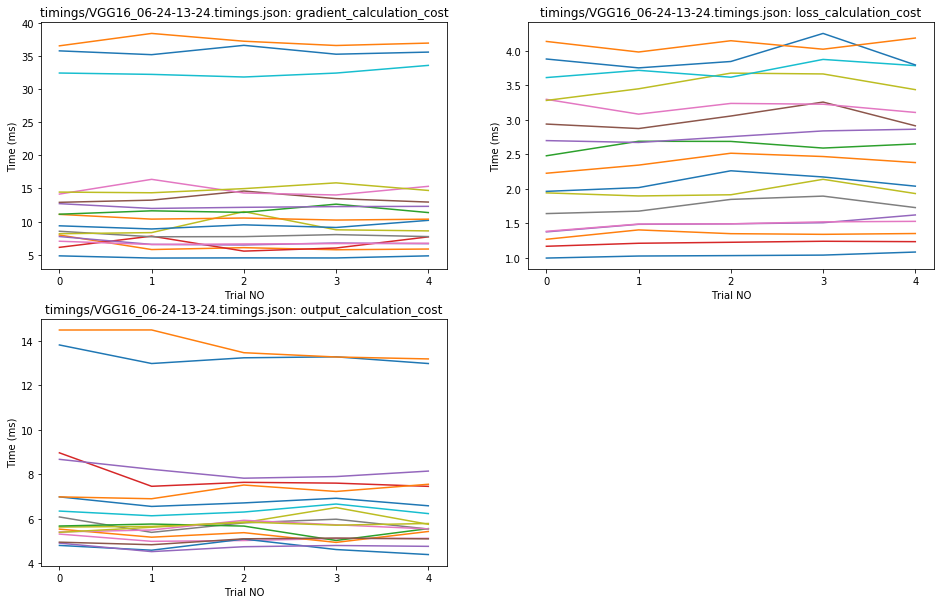

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: True
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


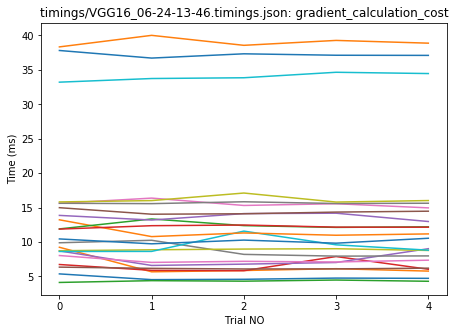

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: True
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


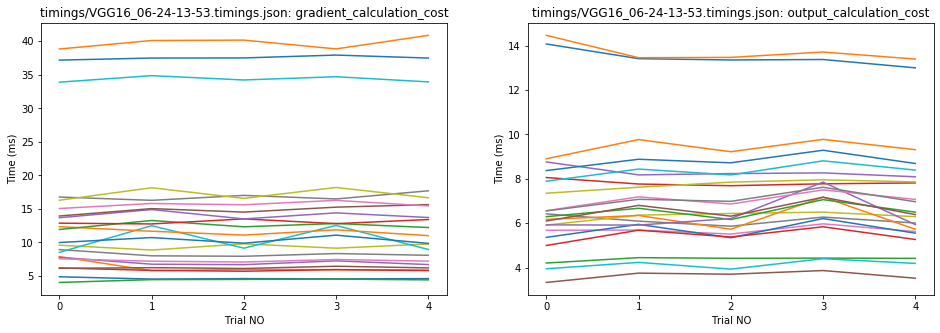

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: False
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


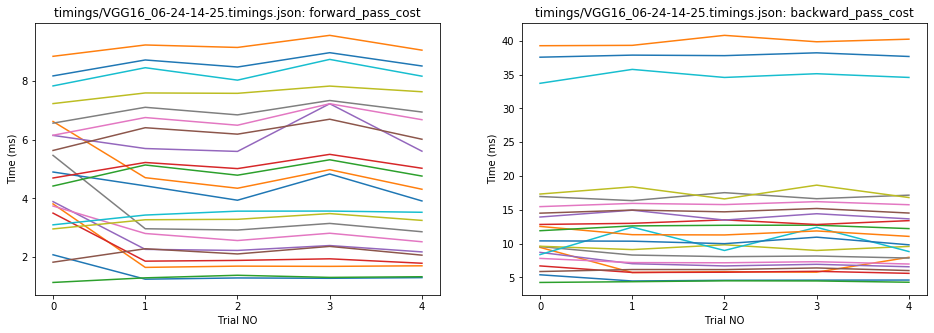

In [105]:
skip_first_layer = False
for i, report in enumerate(reports):
    for item in report["args"].items():
        print("{:10}: {}".format(*item))
    timings = report["timings"]
    normalizing_factor = report["args"]["samples"] * 10**6 # Milliseconds instead of nano seconds
    c = 1
    costs = set(list(timings.values())[0].keys()) - {"Type"}
    plt.figure(figsize=(16,5 * math.ceil(len(costs)/2)))
    for cost_name in costs:
        import math
        plt.subplot(math.ceil(len(costs)/2), 2, c)
        c += 1
        for layer_name in list(timings.keys())[(1 if skip_first_layer else 0):]:
            data = np.array(timings[layer_name][cost_name])
            plt.plot(range(len(data)),  data / normalizing_factor, label=layer_name)
        plt.xlabel("Trial NO")
        plt.ylabel("Time (ms)")
        plt.xticks(range(len(data)))
        #plt.legend()
        plt.title("{}: {}".format(report_paths[i], cost_name))
    plt.show()

### Layer wise costs

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: True
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


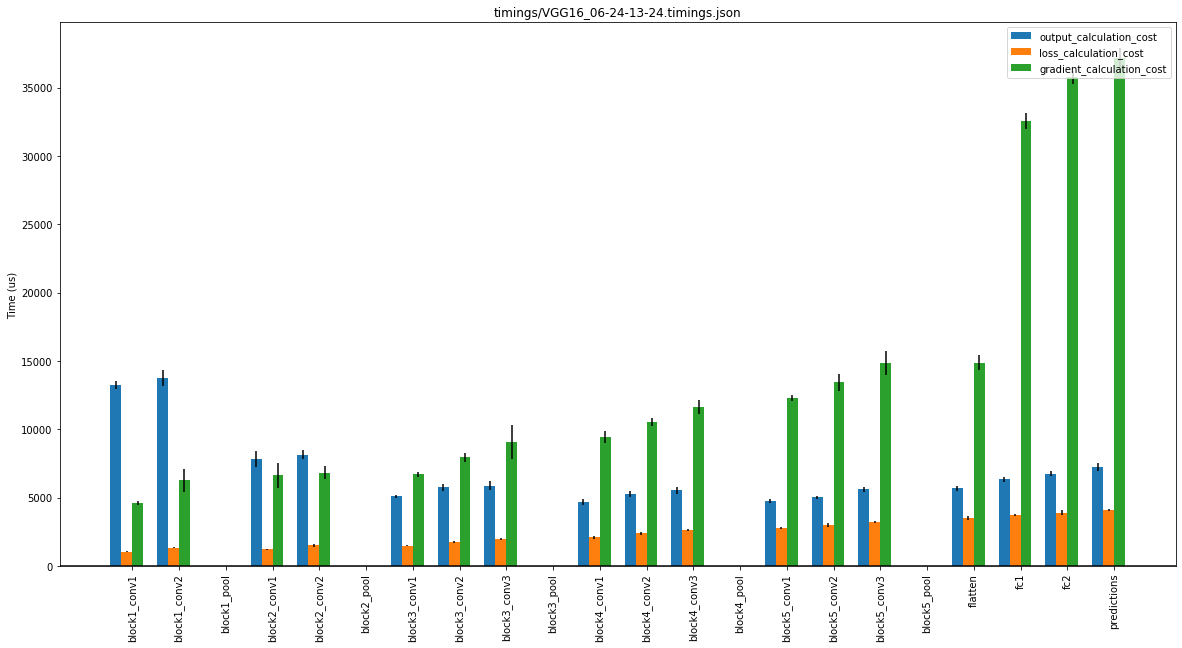

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: True
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


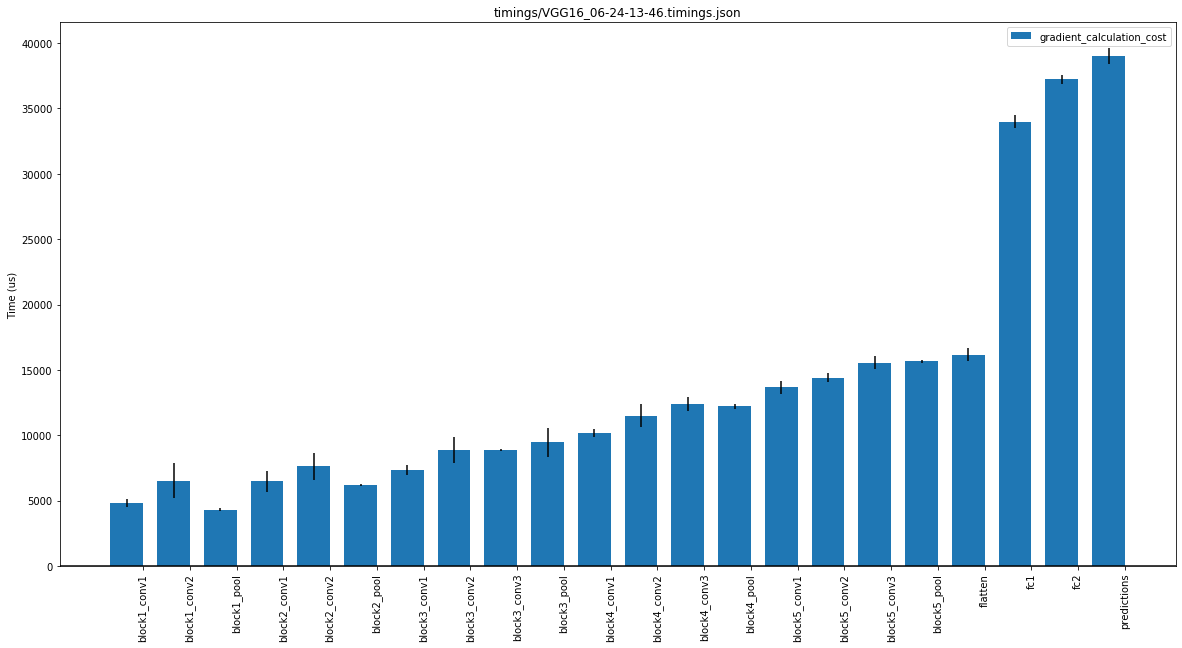

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: True
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


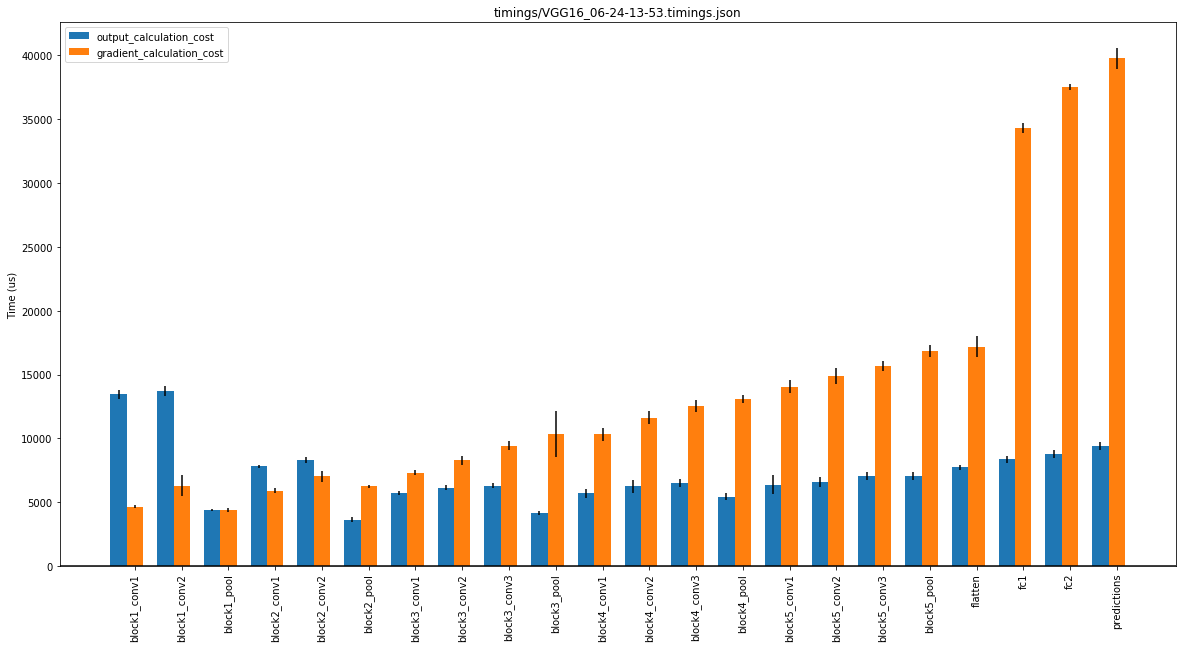

model     : VGG16
loss      : binary_crossentropy
optimizer : sgd
device    : gpu
samples   : 128
num_calls : 1
trials    : 5
full_profiling: False
suppress_negatives: False
no_warmup : False
accumulative: True
out       : None
log       : None


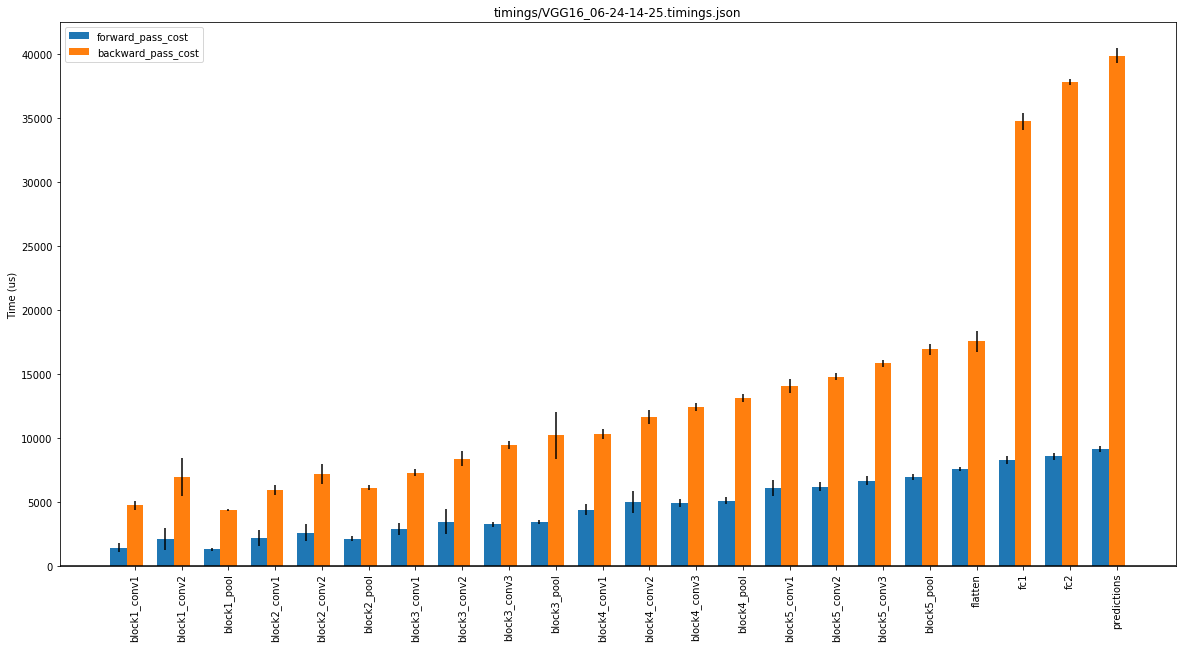

In [106]:
skip_first_layer = False
stacked = False
costs = ["forward_pass_cost", "backward_pass_cost", "output_calculation_cost", "loss_calculation_cost",
         "gradient_calculation_cost", "gradient_application_cost"]
width = 0.7
for i, report in enumerate(reports):
    for item in report["args"].items():
        print("{:10}: {}".format(*item))
    timings = report["timings"]
    N = len(timings) - (1 if skip_first_layer else 0)
    normalizing_factor = report["args"]["samples"] * 10**3 # Microseconds instead of nano seconds
    means = dict()
    stds = dict()
    xticks = list()
    for layer_name in list(timings.keys())[(1 if skip_first_layer else 0):]:
        for cost_name in costs:
            if not cost_name in timings[layer_name].keys():
                continue
            if cost_name not in means.keys():
                means[cost_name] = list()
            if cost_name not in stds.keys():
                stds[cost_name] = list()
            data = np.array(timings[layer_name][cost_name]) / normalizing_factor
            means[cost_name].append(np.mean(data))
            stds[cost_name].append(np.std(data))
        xticks.append(layer_name)

    plt.figure(figsize=(20,10))
    ind = np.arange(N)    # the x locations for the groups
    
    if stacked:
        accumulated_means = np.zeros(shape=N)
        for cost in means.keys():
            p = plt.bar(ind, means[cost], width, yerr=stds[cost], bottom=accumulated_means, label=cost)
            accumulated_means += means[cost]
    else:
        n = len(means)
        for j, cost in enumerate(means.keys()):
            p = plt.bar(ind - width/2 + width/n*j, means[cost], width/n, yerr=stds[cost], label=cost)
            

    plt.ylabel('Time (us)')
    plt.title(report_paths[i])
    plt.xticks(ind, xticks, rotation="vertical")
    plt.legend()
    plt.axhline(0, color='black')
    plt.show()


### Layer type wise costs